# Simulation of a **pin** silicon solar cell

The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import calc_p_density, calc_n_density, calc_recombination

import synumses.one_dimension.solver as solver

## Definition of the solar cell
The silicon has a thickness of $l_\mathrm{x}=1\,\mathrm{\mu m}$ and the first and last  $50\,\mathrm{nm}$ are p and n doped, respectively.'<br>
There is no recombination.

In [2]:
parameters.n = 1000
parameters.lx = 1000E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24

Na = 1.0E24
Nd = 1.0E24

Chi = 4.05
Eg = 1.12


# pn transistion at x1
x1 =  50E-9
x2 = 950E-9

for i in range(0, parameters.n):
    
    parameters.Chi[i] = Chi
    parameters.Eg[i] = Eg
    parameters.C[i]  = 0.0
    
    if parameters.pos_x[i] < x1:      
        parameters.C[i]  = -Na
        
    if parameters.pos_x[i] > x2:       
        parameters.C[i]  = Nd

## Plot diagram and doping levels

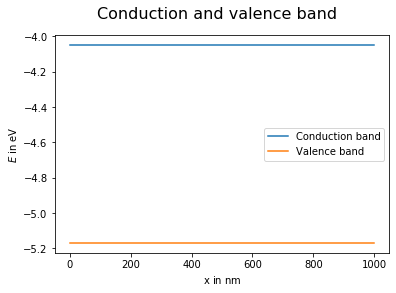

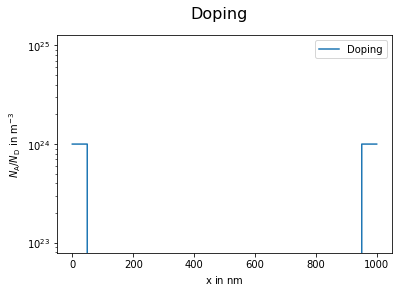

In [3]:
#
# Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.Chi, label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.Chi-parameters.Eg, label='Valence band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Doping level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


## Solving without biasing
Now, let's apply a voltage of $0\,\mathrm{mV}$!.

In [4]:
solver.solve_from_doping()

solver.solve_no_bias()
bias_point = 0.0

solver.solve_bias(bias_point,0)

/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


True

## Plot the band diagram

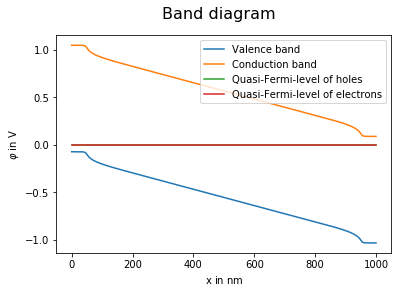

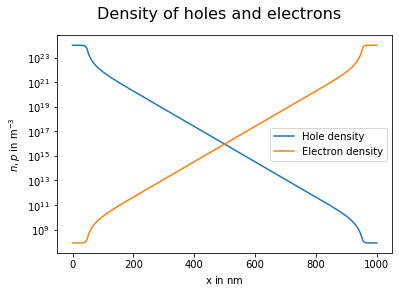

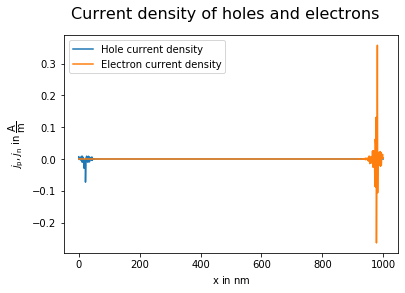

In [5]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

axis.legend()

plt.savefig("Band_Diagramm_PIN.png")
plt.show()

#
# Electron and hole density
#
calc_p_density()
calc_n_density()
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n,p$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


# Electron and hole current density 
j_p =     hole_current_density()
j_n = electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
plt.show()

## Simulation with illumination
Now we illuminate the solar cell and simulate the short circuit current density.<br>
We assume a powerdensity of $1\,\mathrm{\dfrac{kW}{m^3}}$,
an absorption coefficient for silicon of $\alpha_\mathrm{Si} = 2.0\cdot 10^{6}\,\mathrm{m^{-1}}$, and
a light efficiency of $\eta = 0.6$. <br>
For the simulation to converge, the illumination must be ramped up, this takes some time.<br>


In [6]:
# For the simulatoin the illumination starts
# 10nm after and stops 10nm before the contacts.
x1 = 10E-9
x2 = 990E-9


bias_point = 0.0

eta = 0.6

I0 = 1E3

alpha = 2E6

dI0 = alpha*I0*eta

steps = 23

for i in range(steps):

    print("Step:", i,
          "Generation rate at the surface",
          dI0/(2**steps) * 2**(i+1) /(parameters.q * Eg))

    parameters.generation = np.where((parameters.pos_x  > x1) & (parameters.pos_x < x2),
                                     dI0/(2**steps) * 2**(i+1) * np.exp(-parameters.pos_x*alpha) /(parameters.q * Eg),
                                     0)

    solver.solve_bias(-bias_point,0)
    
    j = np.mean(hole_current_density() + electron_current_density())
    
    print("\t Current density:", j)
    

Step: 0 Generation rate at the surface 1.596552985055106e+21
	 Current density: 0.0003081131124168482
Step: 1 Generation rate at the surface 3.193105970110212e+21
	 Current density: 0.00021558991813495676
Step: 2 Generation rate at the surface 6.386211940220424e+21
	 Current density: -0.0010589800436520372
Step: 3 Generation rate at the surface 1.2772423880440847e+22
	 Current density: -0.0016571248128624504
Step: 4 Generation rate at the surface 2.5544847760881695e+22
	 Current density: -0.0007761635213360061
Step: 5 Generation rate at the surface 5.108969552176339e+22
	 Current density: -0.003200919779380042
Step: 6 Generation rate at the surface 1.0217939104352678e+23
	 Current density: -0.007184680164098347
Step: 7 Generation rate at the surface 2.0435878208705356e+23
	 Current density: -0.012778209473034638
Step: 8 Generation rate at the surface 4.087175641741071e+23
	 Current density: -0.026245254967530315
Step: 9 Generation rate at the surface 8.174351283482142e+23
	 Current den

## Plot the parameters with illumination
* generation rate,
* hole and electron density, and
* hole and electron current density.

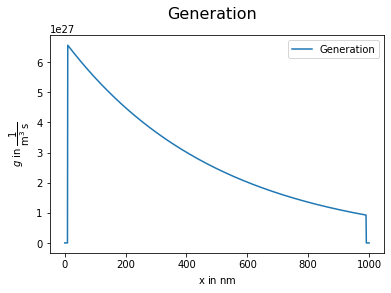

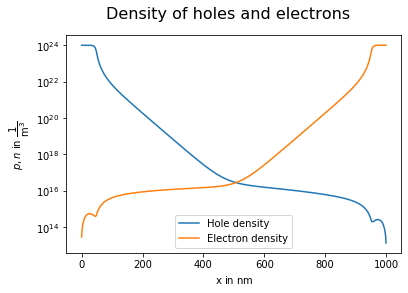

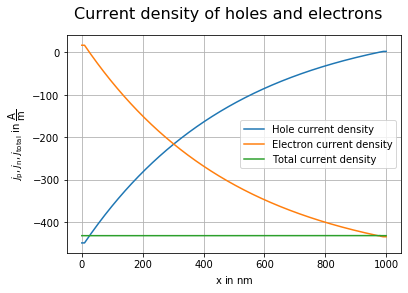

In [7]:
#
# Plot generation rate
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Generation", fontsize=16)

axis.plot(parameters.pos_x * 1E9, parameters.generation, label='Generation')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$g$ in $\mathrm{\dfrac{1}{m^3\, s}}$")

axis.legend()
plt.show()

#
# PLot hole and electron density
#
calc_p_density()
calc_n_density()

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$p, n$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.legend()
plt.show()

#
# Plot hole and electron current density 
#
j_p =     hole_current_density()
j_n =     electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x * 1E9, j_n+j_p, label='Total current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}, j_\mathrm{total}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
axis.grid()
plt.show()

## Voltage sweep
Now, the voltage is swept to get the characteristics of the solar cell for illumination

In [8]:
u_start = 0.0
u_stop  = 0.60
u_step  = 0.025

voltage = []
current_density = []

bias_points = np.linspace(u_start, u_stop, int((u_stop-u_start)/u_step) + 2)
for bias_point in bias_points:

    solver.solve_bias(bias_point,0)   
    
    j = np.mean(hole_current_density() + electron_current_density())
    voltage.append(bias_point)
    current_density.append(j)
    print(bias_point, ",", j)
  

0.0 , -431.6292237343892
0.024999999999999998 , -431.59709192219225
0.049999999999999996 , -431.562850258637
0.075 , -431.5267635805503
0.09999999999999999 , -431.487266557425
0.12499999999999999 , -431.45265773802134
0.15 , -431.41082112341684
0.175 , -431.3676818118846
0.19999999999999998 , -431.3220065948179
0.22499999999999998 , -431.27055369902695
0.24999999999999997 , -431.2073182467386
0.27499999999999997 , -431.1224404040852
0.3 , -430.9818452663218
0.32499999999999996 , -430.6986850055468
0.35 , -430.0476610914134
0.37499999999999994 , -428.4520520079803
0.39999999999999997 , -424.3708199448708
0.425 , -413.78442901460886
0.44999999999999996 , -386.1286210879615
0.475 , -313.689267924357
0.49999999999999994 , -123.73475268140027
0.5249999999999999 , 374.42495665988974
0.5499999999999999 , 1680.1049013157276
0.575 , 5097.38039538575
0.6 , 14017.112844401103


## Plot solar cell characteristics
* the current density and 
* the power density.

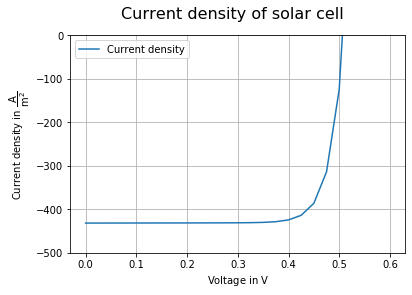

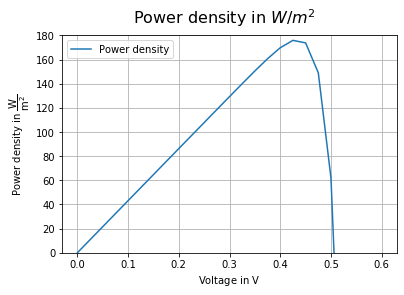

In [9]:
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of solar cell", fontsize=16)

axis.plot(voltage, current_density, label='Current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(-500,0)
plt.show()


# Power density
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Power density in $W/m^2$", fontsize=16)

axis.plot(voltage, -np.array(current_density)*np.array(voltage), label='Power density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Power density in $\mathrm{\dfrac{W}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(0,180)
plt.show()

In [10]:
np.save("current_density_pin.data",np.array(current_density))

In [11]:
cd_pin= np.load("current_density_pin.data.npy")

voltage_other = np.load("voltage.data.npy")
#cd_20E22 = np.load("current_density_20E22.data.npy")
cd_16E22 = np.load("current_density_16E22.data.npy")
cd_8E22 = np.load("current_density_8E22.data.npy")
cd_4E22 = np.load("current_density_4E22.data.npy")
cd_1E22 = np.load("current_density_1E22.data.npy")
cd_025E22 = np.load("current_density_025E22.data.npy")
cd_0125E22 = np.load("current_density_0125E22.data.npy")
cd_00675E22 = np.load("current_density_00675E22.data.npy")

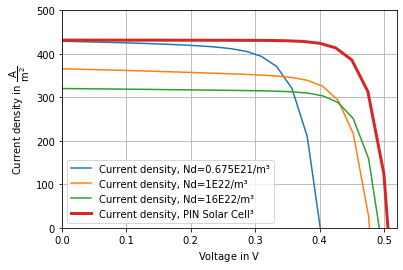

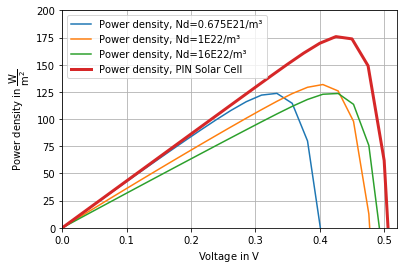

In [15]:
fig, axis = plt.subplots(1,1, sharey=True)
#fig.suptitle("Current density of solar cell", fontsize=16)


axis.plot(voltage_other, -cd_00675E22, label='Current density, Nd=0.675E21/m³')
#axis.plot(voltage_other, -cd_0125E22, label='Current density, Nd=1.25E21/m³')
axis.plot(voltage_other, -cd_1E22, label='Current density, Nd=1E22/m³')
#axis.plot(voltage_other, -cd_8E22, label='Current density, Nd=8E22/m³')
axis.plot(voltage_other, -cd_16E22, label='Current density, Nd=16E22/m³')
#axis.plot(voltage_other, -cd_20E22, label='Current density, Nd=20E22/m³')

axis.plot(voltage, -cd_pin, label='Current density, PIN Solar Cell³', lw = 3)


axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(00,500)
plt.xlim(0, .52)
plt.savefig("Output_Characteristsics_PIN.png")
plt.show()


# Power density
fig, axis = plt.subplots(1,1, sharey=True)
#fig.suptitle("Power density in $W/m^2$", fontsize=16)

axis.plot(voltage_other, -cd_00675E22*np.array(voltage_other), label='Power density, Nd=0.675E21/m³')
#axis.plot(voltage_other, -cd_0125E22*np.array(voltage_other), label='Power density, Nd=1.25E21/m³')
axis.plot(voltage_other, -cd_1E22*np.array(voltage_other), label='Power density, Nd=1E22/m³')
#axis.plot(voltage_other, -cd_8E22*np.array(voltage_other), label='Power density, Nd=8E22/m³')
axis.plot(voltage_other, -cd_16E22*np.array(voltage_other), label='Power density, Nd=16E22/m³')
#axis.plot(voltage_other, -cd_32E22*np.array(voltage_other), label='Power density, Nd=32E22/m³')

axis.plot(voltage, -cd_pin*np.array(voltage), label='Power density, PIN Solar Cell',lw = 3)


axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Power density in $\mathrm{\dfrac{W}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(0,200)
plt.xlim(0, .52)
plt.savefig("Power_Density_PIN.png")
plt.show()